In [1]:
# import packages
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.stats as sms
import statsmodels.stats.api as smss
from scipy import stats
import numpy as np
import warnings
warnings.filterwarnings('ignore')

C:\Users\zblack\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# import data
df = pd.read_csv('BGVSpringboardData.csv')

In [3]:
#Set TourID to index
df= df.set_index('TourID_dimension')

# create dictionary to change binary categorical output variable to an integer
dic = {'Sale':1,'No Sale':0}

dic1 = {'Yes':1,'No':0}

dic2 = {'In State':1,'Out of State':0}

dic3 = {'Owner':1,'1st Gen':0}

dic4 = {'Couple':1,'Single':0}

dic5 = {'Weekday':0, 'Weekend':1}


# convert binary categorical output variable to integer values ) and 1
df['ResultOfTour']=df['ResultOfTour'].replace(dic)

df['Homeowner']=df['Homeowner'].replace(dic1)

df['InState']=df['InState'].replace(dic2)

df['FirstGenVsOwner']=df['FirstGenVsOwner'].replace(dic3)

df['relationStatus']=df['relationStatus'].replace(dic4)

df['WeekdayOrWeekend']=df['WeekdayOrWeekend'].replace(dic5)

print(df.info())


print(len(df))
pU, pL = np.percentile(df['Age'], [99.85 ,0.15])
df = df.loc[df['Age'] <= (pU)]
df = df.loc[df['Age'] >= (pL)]
print(len(df))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15761 entries, 146456 to 384973
Data columns (total 15 columns):
?TourContractGeneration       15761 non-null int64
?TourGeneration               15761 non-null int64
Age                           15761 non-null int64
AgentLine                     15761 non-null object
BookingWindow                 15761 non-null object
FirstGenVsOwner               15761 non-null int64
HHIncomeRanges                15761 non-null object
Homeowner                     15761 non-null int64
InState                       15761 non-null int64
Programs (Budget)             15761 non-null object
relationStatus                15761 non-null int64
ResultOfTour                  15761 non-null int64
TourSeason                    15761 non-null object
WeekdayOrWeekend              15761 non-null int64
NetVolumePlusNonGoodVolume    15761 non-null float64
dtypes: float64(1), int64(9), object(5)
memory usage: 1.9+ MB
None
15761
15736


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

dfX = df.drop(['ResultOfTour',  'AgentLine', 'NetVolumePlusNonGoodVolume'], axis = 1)

dfX = pd.get_dummies(dfX, prefix=['BookingWindow',
       'HHIncomeRanges', 'Programs (Budget)','TourSeason'])
                                  
scaler1 = StandardScaler()
scaler1.fit(dfX[['Age']])
dfX['Age'] = scaler1.transform(dfX[['Age']])

scaler2 = StandardScaler()
scaler2.fit(dfX[['?TourContractGeneration']])
dfX['?TourContractGeneration'] = scaler2.transform(dfX[['?TourContractGeneration']])

scaler3 = StandardScaler()
scaler3.fit(dfX[['?TourGeneration']])
dfX['?TourGeneration'] = scaler3.transform(dfX[['?TourGeneration']])
       

X_train, X_test, y_train, y_test = train_test_split(dfX, df['ResultOfTour'], stratify=df['ResultOfTour'], test_size=0.2,random_state = 42)




dfX1 = X_train
dfY1 = y_train
 



print(dfX1.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12588 entries, 374957 to 361176
Data columns (total 38 columns):
?TourContractGeneration                        12588 non-null float64
?TourGeneration                                12588 non-null float64
Age                                            12588 non-null float64
FirstGenVsOwner                                12588 non-null int64
Homeowner                                      12588 non-null int64
InState                                        12588 non-null int64
relationStatus                                 12588 non-null int64
WeekdayOrWeekend                               12588 non-null int64
BookingWindow_Inside 2 Days                    12588 non-null uint8
BookingWindow_Inside 90 days                   12588 non-null uint8
BookingWindow_Inside Half Year                 12588 non-null uint8
BookingWindow_Inside Month                     12588 non-null uint8
BookingWindow_Inside Week                      12588 non-null u

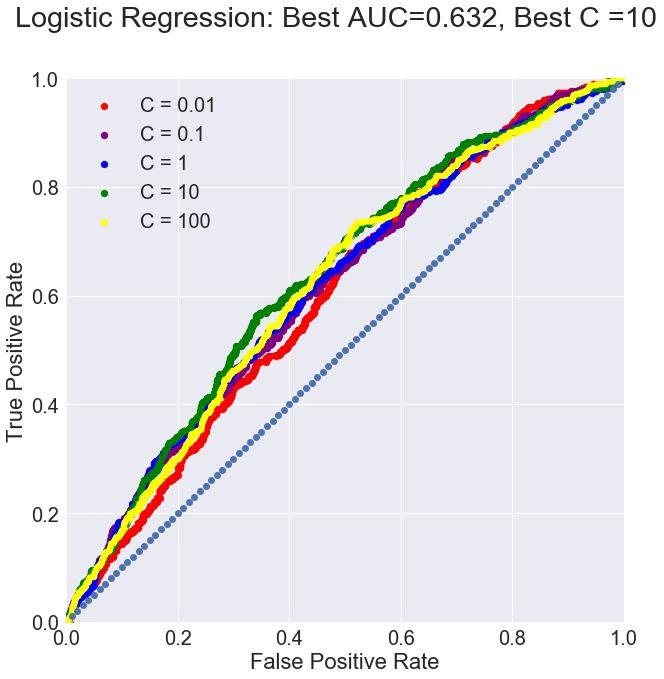

In [5]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve

bestC = 0
bestAUCC = 0
i = 0
colors= ['red','purple','blue','green','yellow']

#make cross validation of c values and kfold
Cs = [0.01, 0.1, 1,10,100]
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#change  figure size
mpl.rcParams['figure.figsize'] = (10,10)


#ROC plot of model accuracy
sns.set(font_scale = 2)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

for train, test in kf.split(dfX1,dfY1):
    lr = LogisticRegression(C=Cs[i])
    lr.fit(dfX1.iloc[train.tolist()],dfY1.iloc[train.tolist()])
    preds = lr.predict_proba(dfX1.iloc[test.tolist()])[:,1]
    fpr, tpr, threshold = metrics.roc_curve(dfY1.iloc[test.tolist()], preds)
    auc = metrics.auc(fpr,tpr)
    if auc>bestAUCC:
        bestC=Cs[i]
        bestAUCC=auc
    i += 1 
    plt.scatter(x=fpr, y=tpr, c = colors[i-1],label='C = '+str(Cs[i-1]))
    plt.plot(fpr,tpr, color = colors[i-1], linewidth=6.0)
plt.legend()    
plt.suptitle('Logistic Regression: Best AUC='+str(round(bestAUCC,3))+', Best C ='+str(bestC))
x = np.arange(1, 100)/100
y=x
plt.plot(x,y,'o')
plt.show()

In [6]:
from sklearn.model_selection import GridSearchCV
parameters={
'C': [0.01, 0.1, 1,10,100],
}

clf = GridSearchCV(estimator=LogisticRegression(),param_grid=parameters,n_jobs=1,verbose=0,cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='roc_auc' )
clf.fit(dfX1,dfY1)
print(clf.best_params_)
print(clf.best_score_)

{'C': 100}
0.6209781517297014


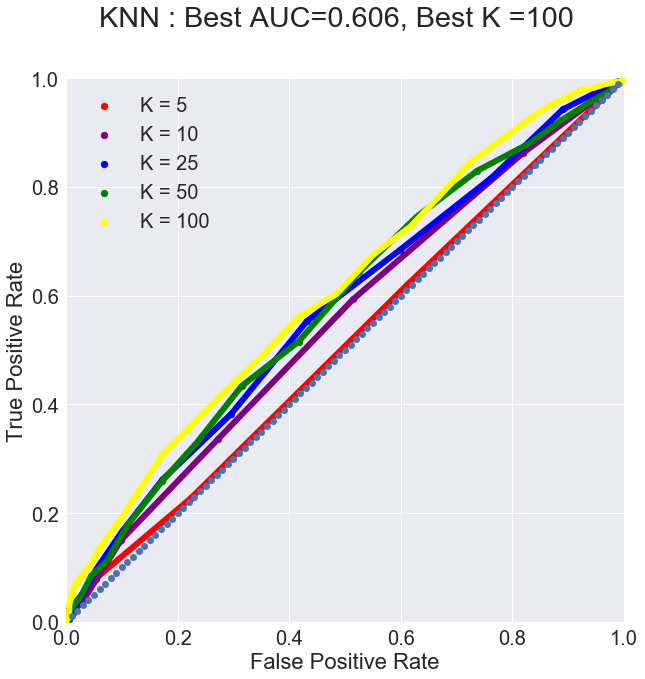

In [7]:
from sklearn.neighbors import KNeighborsClassifier


bestK = 0
bestAUCK = 0
i = 0
colors= ['red','purple','blue','green','yellow']
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#make cross validation of K values and kfold
Ks = [5,10,25,50,100]

#change  figure size
mpl.rcParams['figure.figsize'] = (10,10)


#ROC plot of model accuracy
sns.set(font_scale = 2)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

for train, test in kf.split(dfX1,dfY1):
    knn = KNeighborsClassifier(Ks[i])
    knn.fit(dfX1.iloc[train.tolist()],dfY1.iloc[train.tolist()])
    preds = knn.predict_proba(dfX1.iloc[test.tolist()])[:,1]
    fpr, tpr, threshold = metrics.roc_curve(dfY1.iloc[test.tolist()], preds)
    auc = metrics.auc(fpr,tpr)
    if auc>bestAUCK:
        bestK=Ks[i]
        bestAUCK=auc
    i += 1 
    plt.scatter(x=fpr, y=tpr, c = colors[i-1],label='K = '+str(Ks[i-1]))
    plt.plot(fpr,tpr, color = colors[i-1], linewidth=6.0)
plt.legend()    
plt.suptitle('KNN : Best AUC='+str(round(bestAUCK,3))+', Best K ='+str(bestK))
plt.plot(x,y,'o')
plt.show()


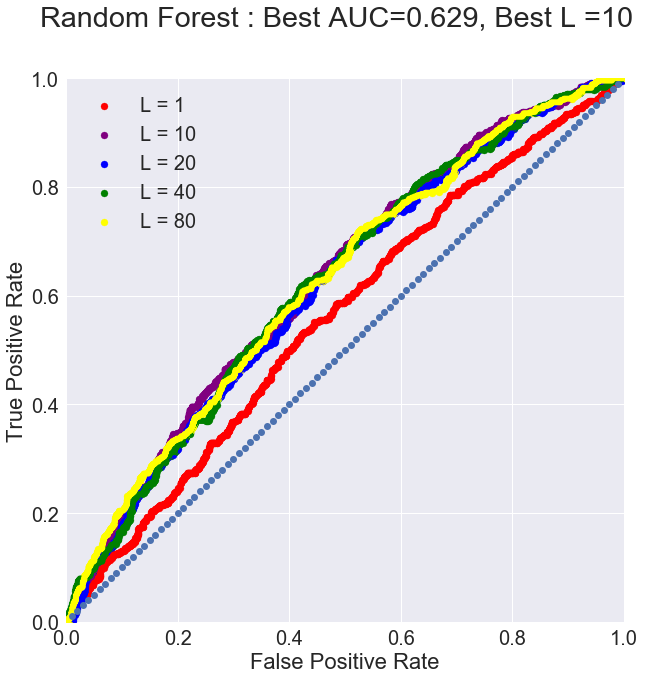

In [8]:
from sklearn.ensemble import RandomForestClassifier

bestL = 0
bestAUCL = 0
bestFeatureImportances= []
i = 0
colors= ['red','purple','blue','green','yellow']
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#make cross validation of K values and kfold
Ls = [1,10,20,40,80]

#change  figure size
mpl.rcParams['figure.figsize'] = (10,10)


#ROC plot of model accuracy
sns.set(font_scale = 2)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

for train, test in kf.split(dfX1,dfY1):
    rfr = RandomForestClassifier(n_estimators=1000,min_samples_leaf=Ls[i], random_state=42)
    rfr.fit(dfX1.iloc[train.tolist()],dfY1.iloc[train.tolist()])
    preds = rfr.predict_proba(dfX1.iloc[test.tolist()])[:,1]
    fpr, tpr, threshold = metrics.roc_curve(dfY1.iloc[test.tolist()], preds)
    auc = metrics.auc(fpr,tpr)
    if auc>bestAUCL:
        bestL=Ls[i]
        bestAUCL=auc
        bestFeatureImportances = rfr.feature_importances_
    i += 1 
    plt.scatter(x=fpr, y=tpr, c = colors[i-1],label='L = '+str(Ls[i-1]))
    plt.plot(fpr,tpr, color = colors[i-1], linewidth=6.0)
plt.legend()    
plt.suptitle('Random Forest : Best AUC='+str(round(bestAUCL,3))+', Best L ='+str(bestL))
plt.plot(x,y,'o')
plt.show()

5


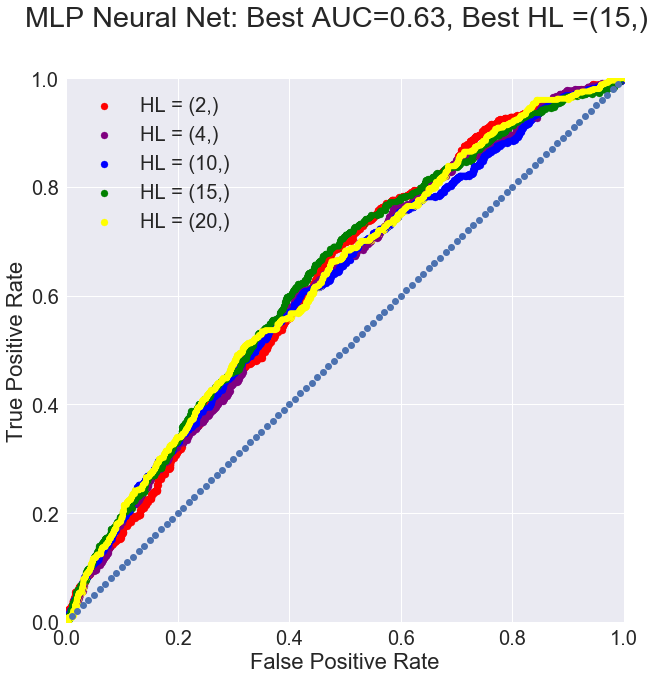

In [9]:
from sklearn.neural_network import MLPClassifier
import itertools

bestHL = 0
bestAUCHL = 0
i = 0
colors= ['red','purple','blue','green','yellow']

#make cross validation of c values and kfold
HLs= [x for x in itertools.product((2,4,10,15,20),repeat=1)]
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print(len(HLs))

#change  figure size
mpl.rcParams['figure.figsize'] = (10,10)


#ROC plot of model accuracy
sns.set(font_scale = 2)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

for train, test in kf.split(dfX1,dfY1):
    lr = MLPClassifier(hidden_layer_sizes=HLs[i])
    lr.fit(dfX1.iloc[train.tolist()],dfY1.iloc[train.tolist()])
    preds = lr.predict_proba(dfX1.iloc[test.tolist()])[:,1]
    fpr, tpr, threshold = metrics.roc_curve(dfY1.iloc[test.tolist()], preds)
    auc = metrics.auc(fpr,tpr)
    if auc>bestAUCHL:
        bestHL=HLs[i]
        bestAUCHL=auc
    i += 1 
    plt.scatter(x=fpr, y=tpr,label='HL = '+str(HLs[i-1]),color=colors[i-1])
    plt.plot(fpr,tpr, linewidth=6.0,color=colors[i-1])
plt.legend()    
plt.suptitle('MLP Neural Net: Best AUC='+str(round(bestAUCHL,3))+', Best HL ='+str(bestHL))
x = np.arange(1, 100)/100
y=x
plt.plot(x,y,'o')
plt.show()

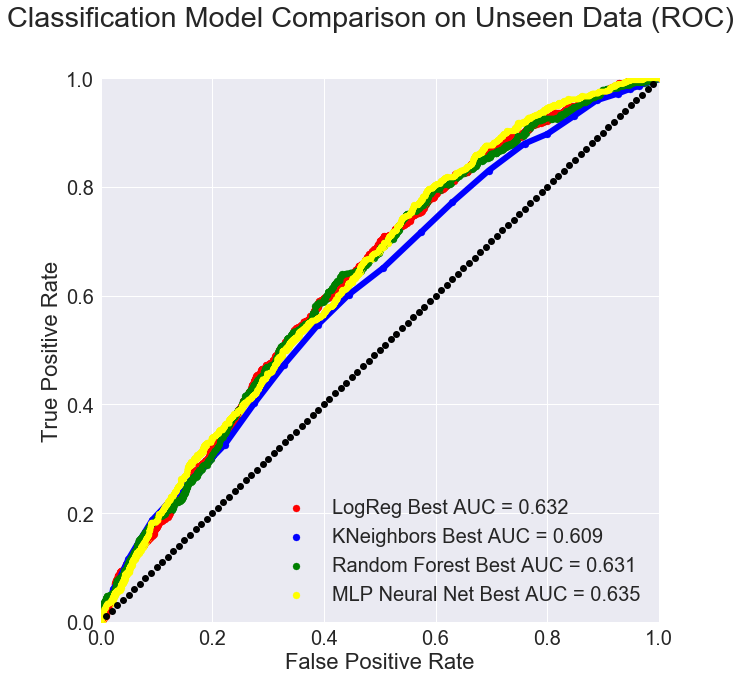

In [10]:
#logistic regregression best model 
lr = LogisticRegression(C=bestC)
lr.fit(dfX1,dfY1)
preds = lr.predict_proba(X_test)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
auc = metrics.auc(fpr,tpr)
# change  figure size
mpl.rcParams['figure.figsize'] = (10,10)
sns.set(font_scale = 2)
#plot ROC Curves of Logistic regression models using best Cs to from kFold Cross Validation
plt.scatter(x=fpr, y=tpr, color = 'Red', label= 'LogReg Best AUC = '+ str(round(auc,3)))
plt.plot(fpr,tpr,color= 'Red',linewidth=6.0)


#knn best model 
knn = KNeighborsClassifier(bestK)
knn.fit(dfX1,dfY1)
preds = knn.predict_proba(X_test)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
auc = metrics.auc(fpr,tpr)
plt.scatter(x=fpr, y=tpr, color = 'Blue', label= 'KNeighbors Best AUC = '+ str(round(auc,3)))
plt.plot(fpr,tpr,color= 'Blue',linewidth=6.0)

#random forest best model 
rf = RandomForestClassifier(n_estimators=1000,min_samples_leaf =bestL,random_state=42)
rf.fit(dfX1,dfY1)
preds = rf.predict_proba(X_test)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
auc = metrics.auc(fpr,tpr)
plt.scatter(x=fpr, y=tpr, color = 'Green', label= 'Random Forest Best AUC = '+ str(round(auc,3)))
plt.plot(fpr,tpr,color= 'Green',linewidth=6.0)

# Neural Net MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=bestHL)
clf.fit(dfX1,dfY1)
preds = clf.predict_proba(X_test)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
auc = metrics.auc(fpr,tpr)
plt.scatter(x=fpr, y=tpr, color = 'Yellow', label= 'MLP Neural Net Best AUC = '+ str(round(auc,3)))
plt.plot(fpr,tpr,color= 'Yellow',linewidth=6.0)

plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.plot(x,y,'o', color='Black')
plt.suptitle('Classification Model Comparison on Unseen Data (ROC)')
plt.show()

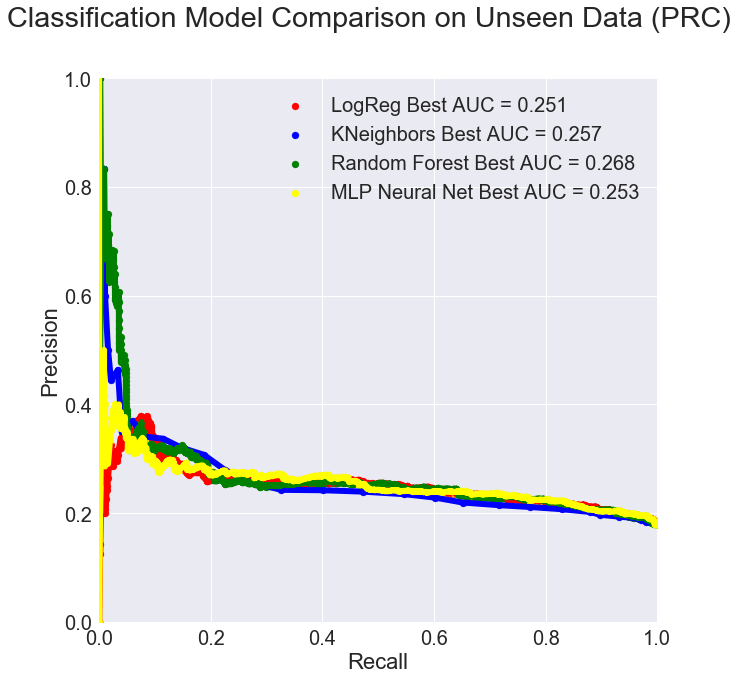

In [11]:
# change  figure size
mpl.rcParams['figure.figsize'] = (10,10)
sns.set(font_scale = 2)
#logistic regregression best model 
lr = LogisticRegression(C=bestC)
lr.fit(dfX1,dfY1)
preds = lr.predict_proba(X_test)[:,1]
p,r, threshold = precision_recall_curve(y_test, preds)
auc = metrics.auc(r,p)
#plot ROC Curves of Logistic regression models using best Cs to from kFold Cross Validation
plt.scatter(x=r, y=p, color = 'Red', label= 'LogReg Best AUC = '+ str(round(auc,3)))
plt.plot(r,p,color= 'Red',linewidth=6.0)



#knn best model 
knn = KNeighborsClassifier(bestK)
knn.fit(dfX1,dfY1)
preds = knn.predict_proba(X_test)[:,1]
p,r, threshold = precision_recall_curve(y_test, preds)
auc = metrics.auc(r,p)
plt.scatter(x=r, y=p, color = 'Blue', label= 'KNeighbors Best AUC = '+ str(round(auc,3)))
plt.plot(r,p,color= 'Blue',linewidth=6.0)

#random forest best model 
rf = RandomForestClassifier(n_estimators=1000,min_samples_leaf =bestL,random_state=42)
rf.fit(dfX1,dfY1)
preds = rf.predict_proba(X_test)[:,1]
p,r, threshold = precision_recall_curve(y_test, preds)
auc = metrics.auc(r,p)
plt.scatter(x=r, y=p, color = 'Green', label= 'Random Forest Best AUC = '+ str(round(auc,3)))
plt.plot(r,p,color= 'Green',linewidth=6.0)

# Neural Net MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=bestHL)
clf.fit(dfX1,dfY1)
preds = clf.predict_proba(X_test)[:,1]
p,r, threshold = precision_recall_curve(y_test, preds)
auc = metrics.auc(r,p)
plt.scatter(x=r, y=p, color = 'Yellow', label= 'MLP Neural Net Best AUC = '+ str(round(auc,3)))
plt.plot(r,p,color= 'Yellow',linewidth=6.0)

x_mis = X_test[y_test !=rf.predict(X_test)]
x_mis['prediction'] = rf.predict(x_mis)
x_mis['actual'] = y_test[y_test != rf.predict(X_test)]

plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.suptitle('Classification Model Comparison on Unseen Data (PRC)')
plt.show()

In [12]:
for x,y in sorted(zip(list(rf.feature_importances_), X_test.columns.tolist()), reverse =True):
    print(round(x,3),y)

0.204 Age
0.117 ?TourGeneration
0.083 ?TourContractGeneration
0.049 InState
0.034 WeekdayOrWeekend
0.031 TourSeason_Winter
0.028 HHIncomeRanges_90k to 149k
0.028 TourSeason_Spring
0.027 BookingWindow_Inside 90 days
0.025 HHIncomeRanges_70k to 89k
0.024 FirstGenVsOwner
0.022 HHIncomeRanges_150k to 199k
0.022 TourSeason_Summer
0.021 Programs (Budget)_(12) Outbound Telemarktng
0.021 HHIncomeRanges_200k to 349k
0.02 Programs (Budget)_(09) GL7 Inhouse
0.02 TourSeason_Fall
0.02 BookingWindow_Inside Month
0.018 BookingWindow_Inside 2 Days
0.017 BookingWindow_Inside Year
0.017 BookingWindow_Inside Week
0.017 Programs (Budget)_(06) GC8 Inhouse
0.015 BookingWindow_Inside Half Year
0.014 relationStatus
0.013 Programs (Budget)_(21) GTL In House
0.012 HHIncomeRanges_350k to 500k
0.011 Programs (Budget)_(17) Guest Member
0.01 HHIncomeRanges_Under 70k
0.009 Programs (Budget)_(14) Summit County OPC
0.008 BookingWindow_Over a Year
0.008 Programs (Budget)_(15) Internet
0.007 Programs (Budget)_(24) Front

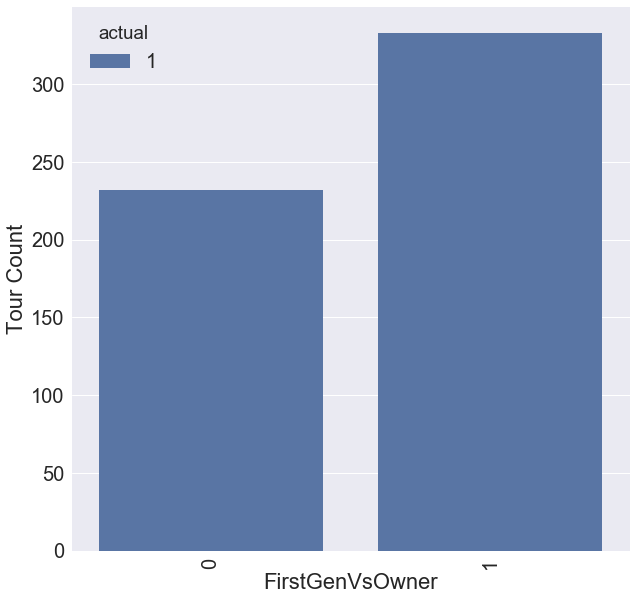

In [13]:
# create countplot of tour count by first gen vs owner misclasifieds
sns.countplot(x= 'FirstGenVsOwner', hue= 'actual', data = x_mis)
plt.ylabel('Tour Count')
plt.xticks(rotation=90)
plt.show()



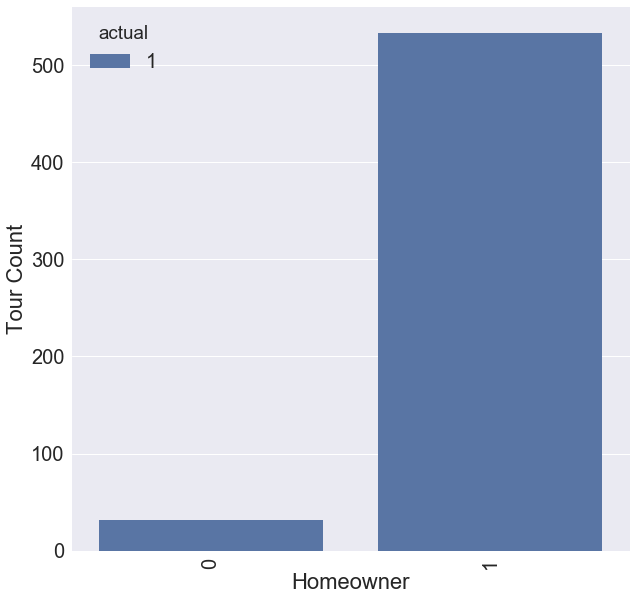

In [14]:
# create countplot of tour count by first gen vs owner misclasifieds
sns.countplot(x= 'Homeowner', hue= 'actual', data = x_mis)
plt.ylabel('Tour Count')
plt.xticks(rotation=90)
plt.show()

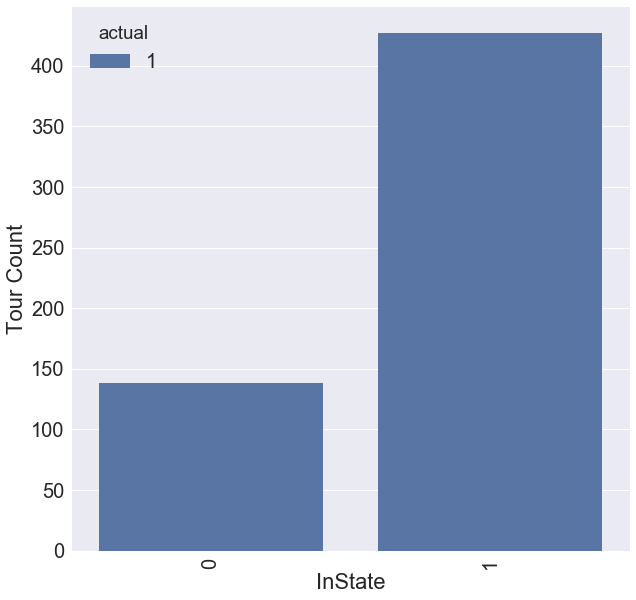

In [15]:
# create countplot of tour count by first gen vs owner misclasifieds
sns.countplot(x= 'InState', hue= 'actual', data = x_mis)
plt.ylabel('Tour Count')
plt.xticks(rotation=90)
plt.show()